In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import pickle
import netCDF4 as nc


In [2]:
def calculate_eddy(width=500e3, num_depth_layers=21, eta0=1, L=1e5, H=1000,
                   a=1, b=1, rho0=1025, f0=None,
                   alpha_1=0.01, alpha_2=0.01,
                   T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None,
                   q11=1.0, q12=0.0, q22=1.0):
    """
    Compute 3D geostrophic U,V and fields for an eddy with prescribed
    quadratic-form shape coefficients q11,q12,q22 (constant in z).
    """
    if f0 is None:
        f0 = 2 * 7.29e-5 * np.sin(np.radians(-34))
    g = 9.81

    x = np.linspace(-width/2, width/2, 21)
    y = np.linspace(-width/2, width/2, 21)
    z = np.linspace(-H, 0, num_depth_layers)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    taper = np.exp(Z / taper_depth) if taper_depth is not None else 1.0

    # center shift with depth
    Xc = alpha_1 * Z
    Yc = alpha_2 * Z

    # elliptical radius-squared
    dX = X - Xc
    dY = Y - Yc
    r2Q = q11 * dX**2 + 2*q12 * dX * dY + q22 * dY**2

    phi = np.exp(-r2Q / L**2) * taper

    T = -2 * phi
    S = 1.5 * phi
    P = -rho0 * g * Z

    alpha = 2e-4
    beta  = 8e-4
    sigma = rho0 * (1 - alpha*(T - T0) + beta*(S - 35))
    sigma -= sigma.mean()

    dx, dy = x[1]-x[0], y[1]-y[0]
    dsdx = np.gradient(sigma, dx, axis=0)
    dsdy = np.gradient(sigma, dy, axis=1)

    U =  g/f0 * dsdy * taper
    V = -g/f0 * dsdx * taper

    # flip so z=0 is first index
    U, V, sigma, T, S, P = [np.flip(arr, axis=2) for arr in (U,V,sigma,T,S,P)]
    z = z[::-1]

    # transpose horizontal slices
    for k in range(U.shape[2]):
        U[:,:,k] = U[:,:,k].T
        V[:,:,k] = V[:,:,k].T

    return U, V, sigma, T, S, P, x/1000, y/1000, z/1000

def plot_ellipse(Q, center=(0, 0), scale=1):
    # def normalize_matrix(A, norm_type='fro'):
    #     norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
    #     return A / norm if norm else A
    # Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):
        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
            
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse
    

In [3]:
def solve_w(U, V, x, y, z, f=-7.7e-5, N2=5e-3):
    # tic = time.time()

    x = x * 1000
    y = y * 1000
    z = z * 1000

    dx, dy = x[1] - x[0], y[1] - y[0]
    nx, ny, nz = U.shape

    # build Q
    dudz = np.gradient(U, z, axis=2)
    dvdz = np.gradient(V, z, axis=2)
    dvdx = np.gradient(V, dx, axis=0)
    dvdy = np.gradient(V, dy, axis=1)
    dudx = np.gradient(U, dx, axis=0)
    dudy = np.gradient(U, dy, axis=1)

    Qx =  f * (dudz * dvdx + dvdz * dvdy)
    Qy = -f * (dudz * dudx + dvdz * dudy)

    S = 2 * (np.gradient(Qx, dx, axis=0) + np.gradient(Qy, dy, axis=1))
    b = S.ravel(order='F')

    # finite difference operators
    ex, ey = np.ones(nx), np.ones(ny)
    Lx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Ly = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(ny, ny)) / dy**2
    Ix, Iy = eye(nx), eye(ny)

    # nonuniform Lz
    Lz = np.zeros((nz, nz))
    for i in range(1, nz - 1):
        dzm = z[i] - z[i - 1]
        dzp = z[i + 1] - z[i]
        Lz[i, i - 1] =  2 / (dzm * (dzm + dzp))
        Lz[i, i]     = -2 / (dzm * dzp)
        Lz[i, i + 1] =  2 / (dzp * (dzm + dzp))
    Lz = csr_matrix(Lz)
    Iz = eye(nz)

    A = N2 * (kron(kron(Iz, Iy), Lx) + kron(kron(Iz, Ly), Ix)) \
      + f**2 * kron(kron(Lz, Iy), Ix)

    w = spsolve(A.tocsr(), b).reshape((nx, ny, nz), order='F')

    # toc = time.time()
    # print(f"Elapsed time: {toc - tic:.4f} seconds")

    return w

def plotter(U, V, w, X, Y, vabs):
    rows, cols = 2, 4
    cmap = plt.get_cmap('coolwarm')
    if vabs is None:
        vabs = np.nanmax(np.abs(w))
    norm = plt.Normalize(vmin=-vabs, vmax=vabs)
    
    fig, axs = plt.subplots(rows, cols, figsize=(3*cols + 1, 3*rows), constrained_layout=True)
    
    for k in range(8):
        ax = axs[k // cols, k % cols]
        if k == 0:
            im = ax.contourf(X, Y, w[:, :, k], cmap=cmap, norm=norm)
        else:
            ax.contourf(X, Y, w[:, :, k], cmap=cmap, norm=norm)
        spacing = 1
        ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
                  U[::spacing, ::spacing, k], V[::spacing, ::spacing, k],
                  color='k', scale=20, alpha=0.4)
        ax.axis('equal')
        ax.set_title(f'Depth {-int(round(z[k]*1000))}m')
    
    # Add communal colorbar to the right
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label(r'w [m Day$^-1$]')
    
    plt.show()


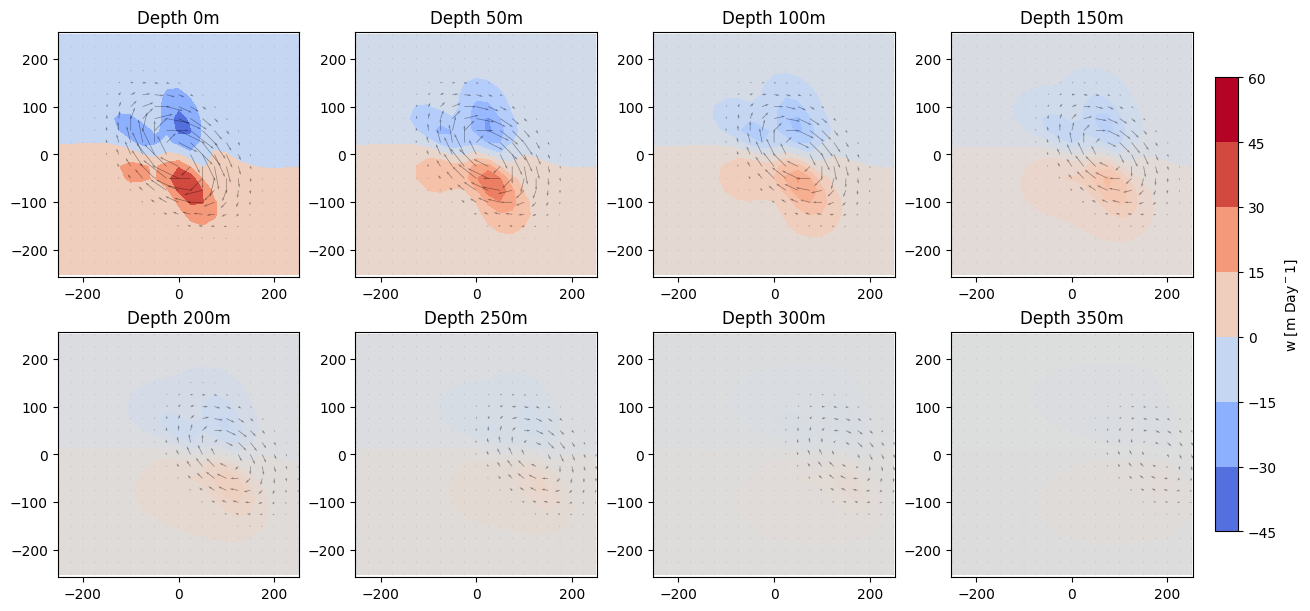

In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400, q11=2, q12=1, q22=2)
alpha_1 = (x[1]-x[0])/(z[1]-z[0]) 
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400, q11=2, q12=1, q22=2, alpha_1=alpha_1)
X, Y = np.meshgrid(x, y)
w = solve_w(U, V, x, y, z)
w = w * 86400
vabs = None #4.5
plotter(U, V, w, X, Y, vabs)



## Eddy Velocity Field Retrieval

We define an **elliptical Gaussian eddy** using a streamfunction

$$
\psi(x, y) = \exp\left(-\frac{1}{2} \phi(x, y)\right)
$$

where the scalar field $\phi$ is quadratic in $x$ and $y$

$$
\phi(x, y) = q_{11}(x - x_0)^2 + 2q_{12}(x - x_0)(y - y_0) + q_{22}(y - y_0)^2.
$$

This gives an elliptical shape controlled by the symmetric matrix $Q$

$$
Q = \begin{bmatrix}
q_{11} & q_{12} \\
q_{12} & q_{22}
\end{bmatrix}.
$$

The geostrophic velocity field is derived from the streamfunction via

$$
u = -\frac{\partial \psi}{\partial y}, \quad v = \frac{\partial \psi}{\partial x}.
$$

We compute the gradients using the chain rule

$$
\frac{\partial \psi}{\partial x} = -\frac{1}{2} \frac{\partial \phi}{\partial x} \exp\left(-\frac{1}{2} \phi\right), \quad
\frac{\partial \psi}{\partial y} = -\frac{1}{2} \frac{\partial \phi}{\partial y} \exp\left(-\frac{1}{2} \phi\right)
$$

with

$$
\frac{\partial \phi}{\partial x} = 2q_{11}(x - x_0) + 2q_{12}(y - y_0),
$$
$$
\frac{\partial \phi}{\partial y} = 2q_{22}(y - y_0) + 2q_{12}(x - x_0).
$$


In [5]:
def dopioe(x1, y1, u1, v1, x2, y2, u2, v2):
    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan

    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common_points = points1 & points2
    
    if len(common_points) != 1:
        print(f"Warning: Expected 1 common point, found {len(common_points)}.")
        return np.nan, np.nan, np.nan, np.nan
    
    center_x, center_y = next(iter(common_points))

    xx = x1 - center_x
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q
    

Im trying to retrieve the velocity field of the eddy throguh my ESM results.\
For that to happen I need to scale the velcoity field and decide a radius of the eddy \
I intend on getting both these things by using the core vorticity calulated by DOPIOE \
I will scale such that the core vorticities match\
I define R as beign where the voriticyt drops to 1/2 the core vorticity

In [6]:
def vel_field_retrieval(x0, y0, Q, R_eff, core_frac=0.5, flag=True):
    """
    Returns:
      X, Y       : grid around (x0,y0)
      u, v       : velocity field (same scaling as dopioe core vorticity)
      R_eff      : effective eddy radius at which core vorticity drops to `core_frac`
    """
    # 1) build grid
    # x = np.linspace(x0 - plot_rad, x0 + plot_rad, 101)
    # y = np.linspace(y0 - plot_rad, y0 + plot_rad, 101)
    if flag:
        x = np.linspace(-150, 150, 101)
        y = np.linspace(-150, 150, 101)
    else: 
        grid_rad = 100
        x = np.linspace(x0-grid_rad, x0+grid_rad, 101)
        y = np.linspace(y0-grid_rad, y0+grid_rad, 101)
    X, Y = np.meshgrid(x, y)
    dx, dy = X - x0, Y - y0

    # 2) core vorticity from dopioe (2·trace Q)
    Qabs = np.abs(Q)
    q11, q12, q22 = Qabs[0,0], Qabs[1,0], Qabs[1,1]
    vort_core = 2*(q11 + q22)

    # 3) quadratic form and its derivatives
    phi   = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
    phi_x = 2*q11*dx  + 2*q12*dy
    phi_y = 2*q22*dy  + 2*q12*dx

    # 5) build Gaussian streamfunction with that R
    exp_term = np.exp(-phi / (2*R_eff**2))
    psi_x = -phi_x / (2*R_eff**2) * exp_term
    psi_y = -phi_y / (2*R_eff**2) * exp_term

    # 6) velocity and rescale so max vorticity matches dopioe core
    u = -psi_y
    v =  psi_x

    # compute gaussian vorticity
    dv_dx = np.gradient(v, axis=1) / np.gradient(X, axis=1)
    du_dy = np.gradient(u, axis=0) / np.gradient(Y, axis=0)
    vort_gauss = np.abs(dv_dx - du_dy)

    # scale factor
    scale = vort_core / np.nanmax(vort_gauss)
    u *= scale
    v *= scale

    return X, Y, u, v


In [7]:
def find_core_radius(u, v, X, Y, x0, y0, Q):
    # 1) compute vorticity and smooth
    dx = np.gradient(X, axis=1)
    dy = np.gradient(Y, axis=0)
    dvdx = np.gradient(v, axis=1) / dx
    dudy = np.gradient(u, axis=0) / dy
    zeta = np.abs(dvdx - dudy)
    zeta = gaussian_filter(zeta, sigma=1)

    # 2) quadratic form “distance”
    s = (X - x0)**2 * Q[0, 0] \
        + 2 * (X - x0) * (Y - y0) * Q[1, 0] \
        + (Y - y0)**2 * Q[1, 1]
    s = np.abs(s)

    # 3) flatten & mask out any NaNs or infinities
    s_flat     = s.flatten()
    zeta_flat  = zeta.flatten()
    good       = np.isfinite(zeta_flat)
    s_fit      = s_flat[good]
    zeta_fit   = zeta_flat[good]

    if len(zeta_fit) == 0:
        return np.nan, np.nan

    # 4) define model and fit
    def gaussian(s, zeta0, Rc2):
        # note: Rc2 = Rc**2
        return zeta0 * np.exp(-s / Rc2)

    try:
        p0      = [zeta_fit.max(), np.median(s_fit)]
        bounds  = ([0, 0], [np.inf, np.inf])
        (zeta0, Rc2), _ = curve_fit(gaussian, s_fit, zeta_fit, p0=p0, bounds=bounds)
    except RuntimeError:
        return np.nan, np.nan

    if Rc2 <= 0:
        return np.nan, np.nan

    # return radius and peak vorticity
    return np.sqrt(Rc2), zeta0


In [9]:
df_dopioe = pd.DataFrame(columns=['x', 'y', 'ic', 'jc', 'w', 'Q', 'Depth', 'Rc'])
ic, jc, r_dx = 9, 9, 2
R_top = 20
for k in range(U.shape[-1]):
# for k in [0]:
# for k in range(4):
    u, v = U[:,:,k], V[:,:,k]
    u1 = u.T[ic - r_dx: ic + r_dx + 1, jc]
    v1 = v.T[ic - r_dx: ic + r_dx + 1, jc]
    x1 = X.T[ic - r_dx: ic + r_dx + 1, jc]
    y1 = Y.T[ic - r_dx: ic + r_dx + 1, jc]
    u2 = u.T[ic, jc - r_dx: jc + r_dx + 1]
    v2 = v.T[ic, jc - r_dx: jc + r_dx + 1]
    x2 = X.T[ic, jc - r_dx: jc + r_dx + 1]
    y2 = Y.T[ic, jc - r_dx: jc + r_dx + 1]

    x0, y0, w, Q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)

    if k == 0:
        x0_old, y0_old = x0, y0
    if np.hypot(x0-x0_old, y0-y0_old) < 50:
        dist = np.hypot(X-x0, Y-y0).T
        ic, jc = np.where(dist==np.min(dist))
        ic = ic[0]
        jc = jc[0]

        # Find core radius
        mask = np.hypot(X - x0, Y - y0) <= 100
        i_mask, j_mask = np.where(mask)
        i_mask = np.arange(i_mask.min(), i_mask.max() + 1)
        j_mask = np.arange(j_mask.min(), j_mask.max() + 1)
        i_mask, j_mask = np.meshgrid(i_mask, j_mask)
        i_mask, j_mask = i_mask.flatten(), j_mask.flatten()
        
        i_min, j_min = i_mask.min(), j_mask.min()
        i_range, j_range = i_mask.max() - i_min + 1, j_mask.max() - j_min + 1
        
        u_core_finder = np.zeros((i_range, j_range))
        v_core_finder = np.zeros((i_range, j_range))
        X_core_finder = np.zeros((i_range, j_range))
        Y_core_finder = np.zeros((i_range, j_range))
        
        for i, j in zip(i_mask, j_mask):
            u_core_finder[i - i_min, j - j_min] = u.T[i, j]
            v_core_finder[i - i_min, j - j_min] = v.T[i, j]
            X_core_finder[i - i_min, j - j_min] = X.T[i, j]
            Y_core_finder[i - i_min, j - j_min] = Y.T[i, j]

        Rc, _ = find_core_radius(u_core_finder.T, v_core_finder.T, X_core_finder.T, Y_core_finder.T, x0, y0, Q)

        df_dopioe.loc[len(df_dopioe)] = {'x': x0, 'y': y0, 'ic': ic, 'jc': jc, 'w': w, 'Q': Q, 'Depth': z[k]*1000, 'Rc': Rc}
        x0_old, y0_old = x0, y0
    else:
        break
        
# norm_w = df_dopioe['w'].abs()
# norm_w = (norm_w - norm_w.min()) / (norm_w.max() - norm_w.min())
# df_dopioe['R'] = R_top * norm_w
df_dopioe


,x,y,ic,jc,w,Q,Depth,Rc
0,0.634908,0.634908,10,10,-0.130784,"[[-0.03269609101643672, -0.016928954838134506]...",0.0,16.276383
1,25.861677,-0.296981,11,10,-0.097121,"[[-0.025094588768486484, -0.011483627071467831...",-50.0,12.357539
2,50.861633,-0.297484,12,10,-0.075638,"[[-0.0195436760888141, -0.00894348324273415], ...",-100.0,9.506982
3,75.861589,-0.297987,13,10,-0.058907,"[[-0.015220623002961547, -0.006965211602593648...",-150.0,8.055626
4,100.861546,-0.298489,14,10,-0.045877,"[[-0.011853827475579105, -0.005424527709758577...",-200.0,7.940644
5,125.861502,-0.298992,15,10,-0.035729,"[[-0.009231765729409641, -0.004224638468250116...",-250.0,9.369226
6,150.861458,-0.299495,16,10,-0.027826,"[[-0.007189702959418239, -0.00329016112433769]...",-300.0,12.269379
7,175.861414,-0.299997,17,10,-0.021671,"[[-0.00559934363145336, -0.0025623873631233436...",-350.0,8.717850
8,200.861371,-0.300500,18,10,-0.016877,"[[-0.004360771130550443, -0.001995594972700452...",-400.0,6.904792
9,231.575622,-3.097473,19,10,-0.011841,"[[-0.002744458295185246, -0.001554175357181363...",-450.0,5.444316


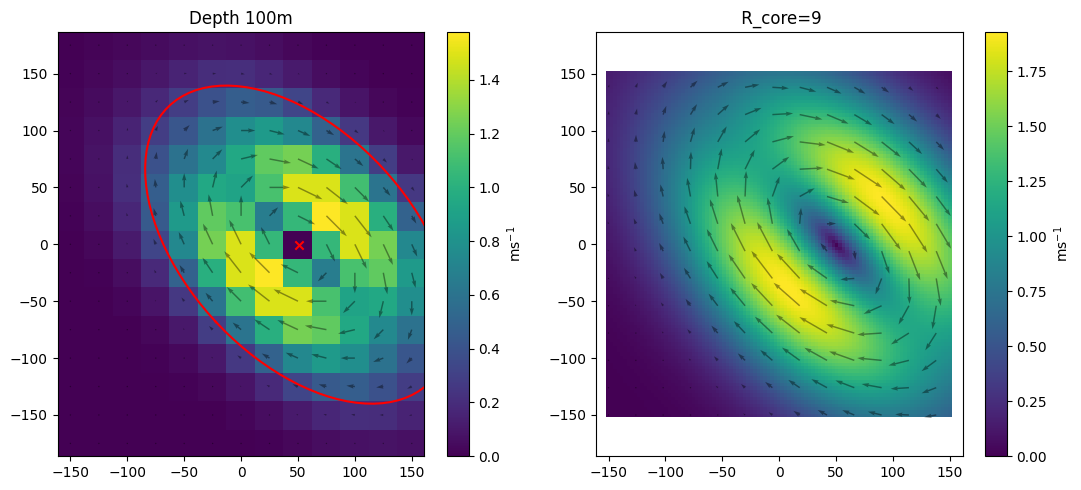

In [23]:
k = 2
data = df_dopioe.loc[k]
x0, y0, Q, R = data['x'], data['y'], data['Q'], data['Rc']

X_ret, Y_ret, u_ret, v_ret = vel_field_retrieval(x0, y0, Q, R)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(11,5))
scale = 20
width=.004
vmax = None
cs = np.hypot(U[:,:,k], V[:,:,k])
pc = axs[0].pcolor(X, Y, cs, vmin=0, vmax=vmax)

fig.colorbar(pc, ax=axs[0], label=r'ms$^{-1}$')
spacing = 1
axs[0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
          U[::spacing, ::spacing, k], V[::spacing, ::spacing, k],
          color='k', scale=scale, alpha=0.4, width=width)
# axs[0].plot(x1, y1)
# axs[0].plot(x2, y2)
x_ell, y_ell = plot_ellipse(Q, center=(x0, y0), scale=1000)
axs[0].plot(x_ell, y_ell, 'r')
axs[0].scatter(x0, y0, marker='x', color='r')
axs[0].axis('equal')
axs[0].set_xlim(-150, 150)
axs[0].set_ylim(-150, 150)
axs[0].set_title(f'Depth {-int(round(z[k]*1000))}m')

# Retrieved velocity field
spacing = 8
pc = axs[1].pcolor(X_ret, Y_ret, np.hypot(u_ret, v_ret), vmin=0, vmax=vmax)
fig.colorbar(pc, ax=axs[1], label=r'ms$^{-1}$')
axs[1].quiver(X_ret[::spacing, ::spacing], Y_ret[::spacing, ::spacing],
          u_ret[::spacing, ::spacing], v_ret[::spacing, ::spacing],
          color='k', scale=scale, alpha=0.4, width=width)
axs[1].axis('equal')
axs[1].set_title(f' R_core={int(R)}')
axs[1].set_xlim(-150, 150)
axs[1].set_ylim(-150, 150)

plt.tight_layout()
plt.show()


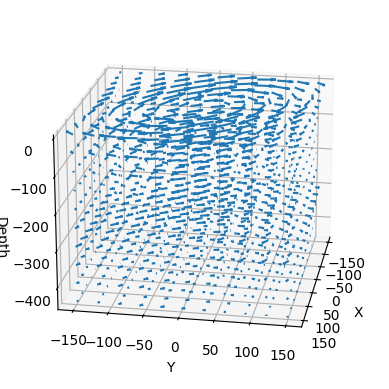

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
length = 10
for k in range(len(df_dopioe)):
    data = df_dopioe.loc[k]
    x0, y0, Q, R, zz = data['x'], data['y'], data['Q'], data['Rc'], data['Depth']
    
    X_ret, Y_ret, u_ret, v_ret = vel_field_retrieval(x0, y0, Q, R)
    Z_ret = zz * np.ones_like(X_ret)
    w_ret = np.zeros_like(u_ret)

    spacing = 10
    ax.quiver(X_ret[::spacing, ::spacing], Y_ret[::spacing, ::spacing], Z_ret[::spacing, ::spacing],
              u_ret[::spacing, ::spacing], v_ret[::spacing, ::spacing], w_ret[::spacing, ::spacing],
              length=length, normalize=False)

ax.view_init(elev=20, azim=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
plt.show()

### ROMS

In [12]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = list(dic_sample.keys())

df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


In [24]:
eddy = sample_eddies[1]
dic = dic_sample[eddy]
day = list(dic.keys())[10]
df_snapshot = dic[day]

fname = df_eddies[(df_eddies['ID']==int(eddy[4:]))&(df_eddies['Day']==int(day[3:]))].iloc[0]['fname']
fnumber = fname[-8:-3]
u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
u_raw = np.where(u_raw > 1e30, np.nan, u_raw).astype(float)
v_raw = np.where(v_raw > 1e30, np.nan, v_raw).astype(float)
with nc.Dataset(fname) as dataset:
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
t_rel = np.where(ocean_time == int(day[3:]))[0][0]

for (x0, y0, Q, k) in zip(df_snapshot['x'], df_snapshot['y'], df_snapshot['Q'], df_snapshot['z']):

    u, v = u_raw[:, :, k, t_rel], v_raw[:, :, k, t_rel]
    u = np.where(mask_rho, u, np.nan)
    v = np.where(mask_rho, v, np.nan)
    
    # Find core radius
    mask = np.hypot(X_grid - x0, Y_grid - y0) <= 100
    i_mask, j_mask = np.where(mask)
    i_mask = np.arange(i_mask.min(), i_mask.max() + 1)
    j_mask = np.arange(j_mask.min(), j_mask.max() + 1)
    i_mask, j_mask = np.meshgrid(i_mask, j_mask)
    i_mask, j_mask = i_mask.flatten(), j_mask.flatten()
    
    i_min, j_min = i_mask.min(), j_mask.min()
    i_range, j_range = i_mask.max() - i_min + 1, j_mask.max() - j_min + 1
    
    u_core_finder = np.zeros((i_range, j_range))
    v_core_finder = np.zeros((i_range, j_range))
    X_core_finder = np.zeros((i_range, j_range))
    Y_core_finder = np.zeros((i_range, j_range))
    
    for i, j in zip(i_mask, j_mask):
        u_core_finder[i - i_min, j - j_min] = u[i, j]
        v_core_finder[i - i_min, j - j_min] = v[i, j]
        X_core_finder[i - i_min, j - j_min] = X_grid[i, j]
        Y_core_finder[i - i_min, j - j_min] = Y_grid[i, j]
    
    Rc, _ = find_core_radius(u_core_finder.T, v_core_finder.T, X_core_finder.T, Y_core_finder.T, x0, y0, Q)
    if 'Rc' in df_snapshot.columns:
        if np.abs(Rc - df_snapshot['Rc'].dropna().iloc[-1]) > 50:
            break
        else:
            df_snapshot.loc[k, 'Rc'] = Rc
    else:
        df_snapshot.loc[k, 'Rc'] = Rc
        

In [25]:
df_snapshot


,x,y,Q,w,z,Depth,TD,Grad,Rc
0,341.177529,488.456769,"[[0.0061214541118953195, -0.001271986082703100...",0.019777,0,-1.783320,0.000000,NaN,8.881541
1,337.284598,487.433079,"[[0.0056032538964395215, -0.001175773766749615...",0.019258,1,-5.879627,4.025276,0.262961,8.579438
2,335.805895,487.203045,"[[0.005535580540648021, -7.453370101301608e-05...",0.019754,2,-10.725783,5.516001,0.155565,8.705790
3,334.673427,485.977317,"[[0.005491654923639926, -6.832007999225931e-05...",0.020744,3,-16.383097,6.960676,1.082351,8.664376
4,334.104468,484.557684,"[[0.0055215865262486785, -0.000114044037239405...",0.021765,4,-22.925581,8.076574,2.495140,9.158966
5,333.963270,483.599345,"[[0.006547967738443798, 0.0005723590727613364]...",0.025817,5,-30.444118,8.697132,6.787173,9.617200
6,336.556226,483.253427,"[[0.006579965871112517, -0.0005130054919089338...",0.025163,6,-39.052712,6.959253,-0.133407,9.208932
7,336.963746,484.360587,"[[0.007093922165133813, -7.837920755245137e-05...",0.024860,7,-48.897638,5.876621,2.716825,8.910945
8,337.135136,485.319233,"[[0.007085426672784154, -2.4459286129760968e-0...",0.024927,8,-60.170639,5.117135,5.593366,8.533437
9,336.554098,486.792729,"[[0.007225449145893344, 0.0006035423781689633]...",0.024250,9,-73.127842,4.913771,-2.535971,8.308695


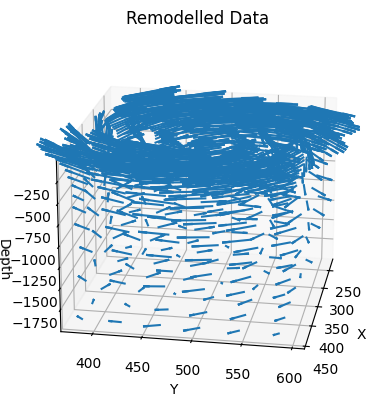

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
length = 80
for k in range(len(df_snapshot)):
    data = df_snapshot.loc[k]
    x0, y0, Q, R, zz = data['x'], data['y'], data['Q'], data['Rc'], data['Depth']

    if not np.isnan(R):
        X_ret, Y_ret, u_ret, v_ret = vel_field_retrieval(x0, y0, Q, R, flag=False)
        Z_ret = zz * np.ones_like(X_ret)
        w_ret = np.zeros_like(u_ret)
    
        spacing = 20
        ax.quiver(X_ret[::spacing, ::spacing], Y_ret[::spacing, ::spacing], Z_ret[::spacing, ::spacing],
                  u_ret[::spacing, ::spacing], v_ret[::spacing, ::spacing], w_ret[::spacing, ::spacing],
                  length=length, normalize=False)

ax.view_init(elev=20, azim=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
ax.set_title('Remodelled Data')
plt.show()


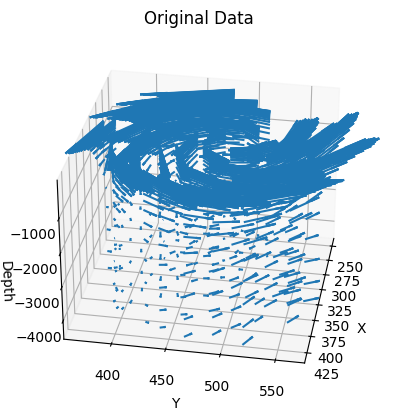

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
length = 80

rad_dis = 100
mask = np.hypot(X_grid-x0, Y_grid-y0).T < rad_dis

X_ret, Y_ret = X_grid.T[mask], Y_grid.T[mask]
for k in range(len(df_snapshot)):
    data = df_snapshot.loc[k]
    x0, y0, Q, R, zz = data['x'], data['y'], data['Q'], data['Rc'], data['Depth']


    u_ret, v_ret = u_raw[:, :, k, t_rel].T[mask], v_raw[:, :, k, t_rel].T[mask]
    Z_ret = zz * np.ones_like(X_ret)
    w_ret = np.zeros_like(u_ret)

    spacing = 50
    ax.quiver(X_ret[::spacing], Y_ret[::spacing], Z_ret[::spacing],
              u_ret[::spacing], v_ret[::spacing], w_ret[::spacing],
              length=length, normalize=False)

ax.view_init(elev=30, azim=10)
ax.set_title('Original Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
plt.show()


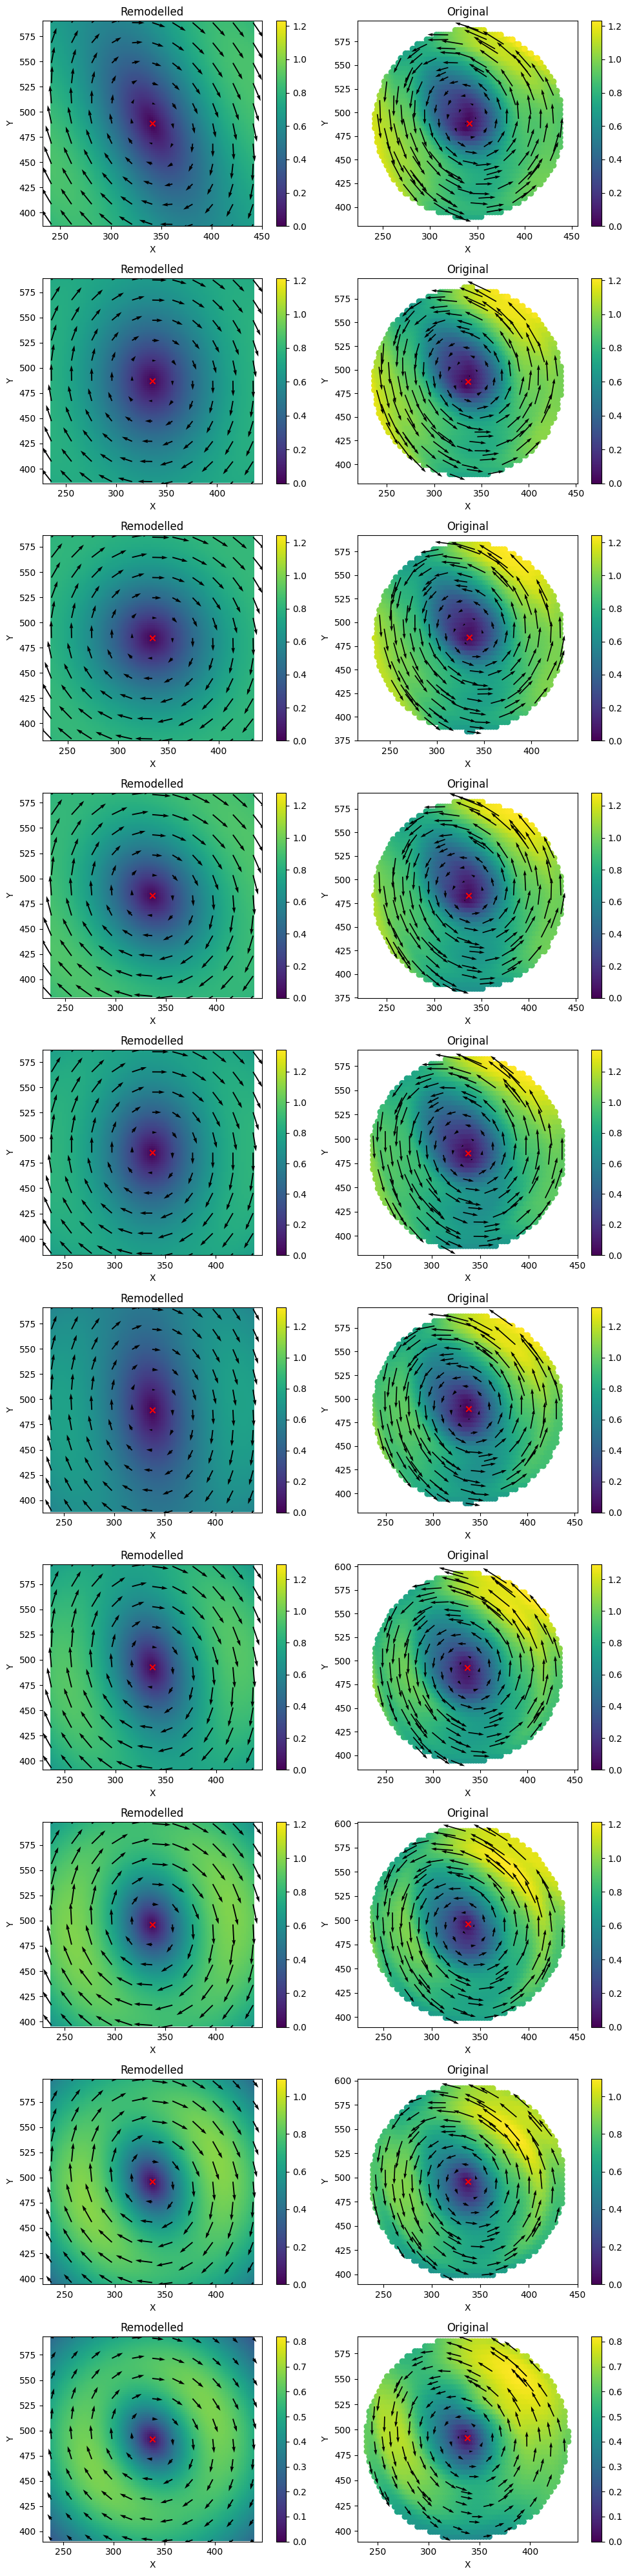

In [29]:
rows, cols = 10, 2
fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 4))

length = 10

for p, k in enumerate(range(0, len(df_snapshot), 2)):
    if p < rows:
        length = 10
        data = df_snapshot.loc[k]
        x0, y0, Q, R, zz = data['x'], data['y'], data['Q'], data['Rc'], data['Depth']

        # Remodelled velocity field
        X_ret, Y_ret, u_mod, v_mod = vel_field_retrieval(x0, y0, Q, R, flag=False)
        # scale = 3
        # u_mod *= scale
        # v_mod *= scale
        mag_modelled = np.hypot(u_mod, v_mod)

        # Original observed velocity field
        rad_dis = 100
        mask = np.hypot(X_grid - x0, Y_grid - y0).T < rad_dis
        X_obs, Y_obs = X_grid.T[mask], Y_grid.T[mask]
        u_obs = u_raw[:, :, k, t_rel].T[mask]
        v_obs = v_raw[:, :, k, t_rel].T[mask]
        mag_obs = np.hypot(u_obs, v_obs)

        # Shared color scale
        vmax = max(mag_modelled.max(), mag_obs.max())

        # Plot remodelled
        pcm = axs[p, 0].pcolor(X_ret, Y_ret, mag_modelled, vmin=0, vmax=vmax, shading='auto')
        spacing = 10
        axs[p, 0].quiver(X_ret[::spacing, ::spacing], Y_ret[::spacing, ::spacing],
                         u_mod[::spacing, ::spacing], v_mod[::spacing, ::spacing], scale=length)
        axs[p, 0].scatter(x0, y0, marker='x', color='r')
        axs[p, 0].set_xlabel('X')
        axs[p, 0].set_ylabel('Y')
        axs[p, 0].set_title('Remodelled')
        axs[p, 0].axis('equal')
        fig.colorbar(pcm, ax=axs[p, 0])

        # Plot observed
        sc = axs[p, 1].scatter(X_obs, Y_obs, c=mag_obs, vmin=0, vmax=vmax)
        spacing = 15
        axs[p, 1].quiver(X_obs[::spacing], Y_obs[::spacing], u_obs[::spacing], v_obs[::spacing], scale=length)
        axs[p, 1].scatter(x0, y0, marker='x', color='r')
        axs[p, 1].set_xlabel('X')
        axs[p, 1].set_ylabel('Y')
        axs[p, 1].set_title('Original')
        axs[p, 1].axis('equal')
        fig.colorbar(sc, ax=axs[p, 1])

plt.tight_layout()
plt.show()
